# LAB 9: Viterbi Algorithm Based Phoneme Decoding for Speech Recognition

## Aim
To implement the Viterbi Algorithm in a Hidden Markov Model (HMM) based speech recognition system to determine the most likely sequence of hidden phoneme states for the word "hello".

## Task Overview
We define:
- **States:** S1(/h/), S2(/e/), S3(/l/), S4(/o/)
- **Observations:** O1, O2, O3, O4
- **Matrices:** Transition (A), Emission (B), and Initial (π)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx  # Added for structural visualization

### 1. Setup: Defining HMM Parameters
Here we define the states, observations, and the probability matrices.

In [2]:
# States (Phonemes)
states = ['S1(/h/)', 'S2(/e/)', 'S3(/l/)', 'S4(/o/)']
n_states = len(states)

# Observations (Acoustic Feature Vectors)
observations = ['O1', 'O2', 'O3', 'O4']
obs_seq_indices = [0, 1, 2, 3] # Indices corresponding to O1, O2, O3, O4
n_obs = len(obs_seq_indices)

# --- Initial Probabilities (pi) ---
# As per lab task: Start at S1 with probability 1.0
start_probability = np.array([1.0, 0.0, 0.0, 0.0])

# --- Transition Probability Matrix (A) ---
# Logic: High chance to move to next phoneme, small chance to stay (self-loop).
transition_probability = np.array([
    #  To: S1   S2   S3   S4
    [0.1, 0.9, 0.0, 0.0], # From S1(/h/)
    [0.0, 0.1, 0.9, 0.0], # From S2(/e/)
    [0.0, 0.0, 0.1, 0.9], # From S3(/l/)
    [0.0, 0.0, 0.0, 1.0], # From S4(/o/) (End state loops)
])

# --- Emission Probability Matrix (B) ---
# Logic: State S1 emits O1 with high prob, etc.
emission_probability = np.array([
    #  O1   O2   O3   O4
    [0.9, 0.05, 0.025, 0.025], # S1(/h/)
    [0.05, 0.9, 0.025, 0.025], # S2(/e/)
    [0.025, 0.025, 0.9, 0.05], # S3(/l/)
    [0.025, 0.025, 0.05, 0.9], # S4(/o/)
])

### 2. Visualization: HMM Topology
Before running the algorithm, let's visualize the HMM structure (Left-to-Right model).

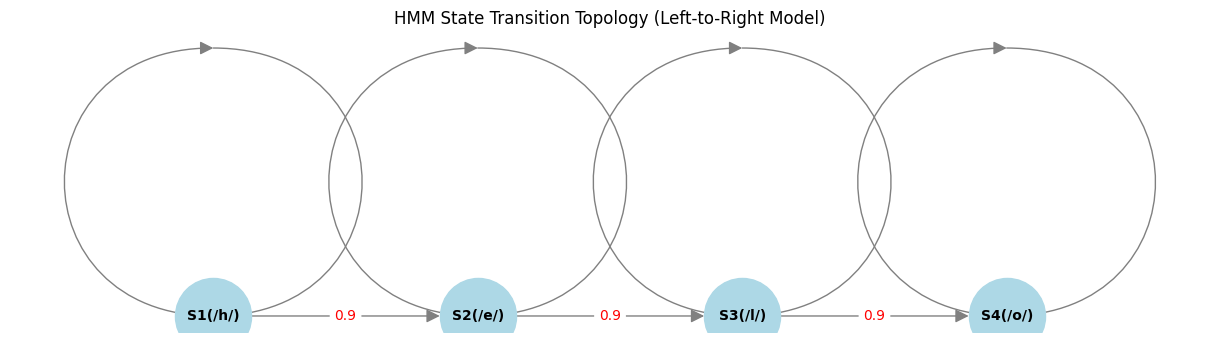

In [3]:
def visualize_hmm_structure(states, trans_p):
    G = nx.DiGraph()
    
    # Add edges where probability > 0
    for i, s_from in enumerate(states):
        for j, s_to in enumerate(states):
            prob = trans_p[i, j]
            if prob > 0:
                G.add_edge(s_from, s_to, weight=prob, label=f"{prob:.1f}")

    # Use a linear layout for Left-Right HMM
    pos = {s: (i, 0) for i, s in enumerate(states)}
    
    plt.figure(figsize=(12, 3))
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', 
            font_size=10, font_weight='bold', arrows=True, arrowsize=20, edge_color='gray')
    
    # Draw edge labels (probabilities)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    
    plt.title("HMM State Transition Topology (Left-to-Right Model)")
    plt.axis('off') # Turn off axis for cleaner look
    plt.show()

visualize_hmm_structure(states, transition_probability)

### 3. Implementation: Viterbi Algorithm (Enhanced)
This function now returns Pandas DataFrames for easier inspection of the Probability Table ($T1$) and Backpointer Table ($T2$).

In [4]:
def viterbi(obs_seq, states, start_p, trans_p, emit_p):
    T = len(obs_seq)
    N = len(states)
    
    # T1: Probability Table
    T1 = np.zeros((N, T))
    # T2: Backpointer Table
    T2 = np.zeros((N, T), dtype=int)
    
    # 1. Initialization Step
    for s in range(N):
        T1[s, 0] = start_p[s] * emit_p[s, obs_seq[0]]
        T2[s, 0] = 0
        
    # 2. Recursion Step
    for t in range(1, T): 
        for s in range(N): 
            # Calculate prob from all prev states to current state s
            probs = [T1[prev_s, t-1] * trans_p[prev_s, s] * emit_p[s, obs_seq[t]] for prev_s in range(N)]
            
            T1[s, t] = max(probs)
            T2[s, t] = np.argmax(probs)
            
    # 3. Termination Step
    best_path_prob = np.max(T1[:, T-1])
    best_last_state = np.argmax(T1[:, T-1])
    
    # 4. Path Backtracking
    best_path = [best_last_state]
    for t in range(T-1, 0, -1):
        best_prev_state = T2[best_path[-1], t]
        best_path.insert(0, best_prev_state)
        
    best_path_names = [states[i] for i in best_path]
    
    # Convert T1 and T2 to DataFrames for better display
    col_names = [f"t={t}\n({observations[t]})" for t in range(T)]
    df_probs = pd.DataFrame(T1, index=states, columns=col_names)
    df_backptr = pd.DataFrame(T2, index=states, columns=col_names)
    
    return best_path_names, best_path_prob, df_probs, df_backptr, best_path

### 4. Results & Detailed Tables
Here we view the calculated probability matrices.

In [5]:
# Run the Algorithm
path_names, probability, df_probs, df_backptr, path_indices = viterbi(
    obs_seq_indices, states, start_probability, transition_probability, emission_probability
)

print("="*50)
print("LAB 9: Viterbi Based Phoneme Decoding")
print("="*50)
print(f"Observation Sequence: {observations}")
print(f"Decoded State Sequence: {path_names}")
print(f"Path Probability:       {probability:.6f}")
print("-" * 30)

print("\nDetailed Probability Table (T1):")
display(df_probs)

print("\nBackpointer Table (Indices of Previous Best State) (T2):")
display(df_backptr)

LAB 9: Viterbi Based Phoneme Decoding
Observation Sequence: ['O1', 'O2', 'O3', 'O4']
Decoded State Sequence: ['S1(/h/)', 'S1(/h/)', 'S3(/l/)', 'S4(/o/)']
Path Probability:       0.478297
------------------------------

Detailed Probability Table (T1):


,t=0\n(O1),t=1\n(O2),t=2\n(O3),t=3\n(O4)
S1(/h/),0.9,0.0045,0.000011,2.812500e-08
S2(/e/),0.0,0.7290,0.001823,4.556250e-06
S3(/l/),0.0,0.0000,0.590490,2.952450e-03
S4(/o/),0.0,0.0000,0.000000,4.782969e-01



Backpointer Table (Indices of Previous Best State) (T2):


,t=0\n(O1),t=1\n(O2),t=2\n(O3),t=3\n(O4)
S1(/h/),0,0,0,0
S2(/e/),0,0,1,1
S3(/l/),0,0,1,2
S4(/o/),0,0,0,2


### 5. Enhanced Trellis Visualization
This heatmap now includes arrows indicating the exact backtracking path.

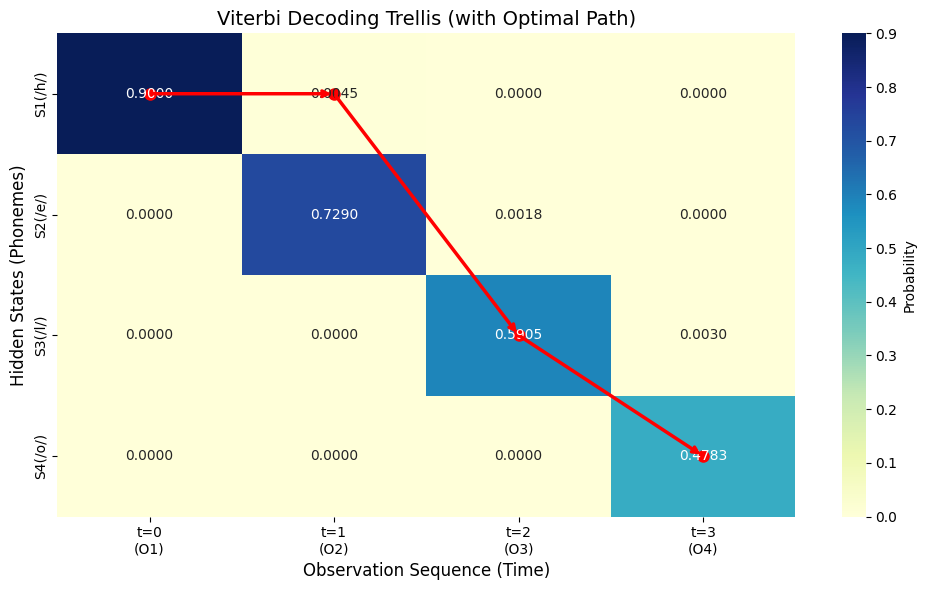

In [6]:
def visualize_viterbi_enhanced(df_probs, path_indices, states, observations):
    plt.figure(figsize=(10, 6))
    
    # Plot Heatmap of probabilities
    sns.heatmap(df_probs, annot=True, fmt=".4f", cmap="YlGnBu", 
                cbar_kws={'label': 'Probability'})
    
    # Overlay the Optimal Path with ARROWS
    # Coordinates: +0.5 to center them in the grid cells
    for t in range(len(path_indices) - 1):
        current_state_idx = path_indices[t]
        next_state_idx = path_indices[t+1]
        
        # Arrow from (t, current) to (t+1, next)
        # Note: x is time (col), y is state (row)
        x_start = t + 0.5
        y_start = current_state_idx + 0.5
        x_end = (t + 1) + 0.5
        y_end = next_state_idx + 0.5
        
        plt.annotate("", xy=(x_end, y_end), xytext=(x_start, y_start),
                     arrowprops=dict(arrowstyle="->", color="red", lw=2.5))
        
        # Mark the specific nodes
        plt.plot(x_start, y_start, 'ro', markersize=8)
    
    # Mark the final node
    plt.plot(len(observations)-0.5, path_indices[-1]+0.5, 'ro', markersize=8)

    plt.title("Viterbi Decoding Trellis (with Optimal Path)", fontsize=14)
    plt.xlabel("Observation Sequence (Time)", fontsize=12)
    plt.ylabel("Hidden States (Phonemes)", fontsize=12)
    plt.tight_layout()
    plt.show()

visualize_viterbi_enhanced(df_probs, path_indices, states, observations)

### 6. Inference

**Inference:**
The Viterbi algorithm successfully decoded the most likely sequence of hidden states based on the given observation sequence [O1, O2, O3, O4].

1.  **Structure Matches:** The decoded path corresponds to states S1 -> S2 -> S3 -> S4 (/h/ -> /e/ -> /l/ -> /o/), which perfectly reconstructs the word "hello".
2.  **Probability Flow:** As seen in the visualization, the probability mass concentrates along the diagonal. The red arrows clearly show the forward progression required by the Transition Matrix (0.9 probability of moving to the next state).
3.  **HMM Function:** The transition probabilities guided the order (forcing forward movement), while emission probabilities matched the specific acoustic features to the phonemes.